In [46]:
# https://www.youtube.com/watch?v=zUyH3XhpLTo

In [47]:
import math
from typing import List
from abc import ABC, abstractmethod

In [54]:
class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def distance_to(self, other: Point) -> float:
        """Calculate the distance between two points."""
        return math.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)


class Vector:
    def __init__(self, magnitude: float, direction: float):
        self.magnitude = magnitude
        self.direction = direction


class Ray:
    def __init__(self, start: Point, vector: Vector):
        self.start = start
        self.direction = direction
        self.current_position = start
        self.data = None


class Manifold:
    def __init__(self, points: List[Point]):
        self.points = points

    @abstractmethod
    def project(self, manifold: Manifold, *args) -> List[Ray]:
        """Project rays onto the 2d render plane.

        This projects the rays from this manifold onto
        the input manifold.
        """
        pass


class Render(Manifold):
    """2D render plane."""

    def __init__(self, num_x, num_y):
        self.area = np.zeros((num_x, num_y))
        super().__init__(list(self.area))

    def render(self, rays: List[Ray]) -> np.ndarray:
        """Render the rays onto the render plane."""
        assert len(rays) == len(self.points)
        for ray, point in zip(rays, self.points):
            self.area[point.x, point.y] = ray.data

In [55]:
from typing import List, Optional


class Viewer(Manifold, ABC):
    """Abstract base class for a viewer."""

    def __init__(self):
        """Defined by some manifold.

        Manifold defines how viewer emits rays and
        how to project rays onto the 2d render plane.
        """
        self.num_rays = 0
        self.rays = []
        super().__init__()

    def run(self):
        """Run the viewer."""
        self.emit_rays()

    @abstractmethod
    def emit_rays(self, N: int, *args) -> List[Ray]:
        """Emit rays from the viewer.

        This emits a grid of rays based on the viewer's manifold.
        The density of the grid is determined by N.
        """
        self.num_rays = N
        pass

    def project_onto_render(self, render_plane: Render):
        render_plane.render(self.rays)


class Screen(Viewer):
    """2D subclass of Viewer"""

    def __init__(self, width: float = 5, height: float = 5):
        """A generic screen that can emit rays."""
        self.width = width
        self.height = height

    def emit_rays(self, num_x: int = None, num_y: int = None) -> List[Ray]:
        """Emit rays from the screen.

        This emits a grid of rays based on the screen's width and height.
        The density of the grid is determined by num_x and num_y.
        """
        if num_x is None:
            num_x = self.width
        if num_y is None:
            num_y = self.height
        super().emit_rays(N=num_x * num_y)
        for x in range(num_x):
            for y in range(num_y):
                self.rays.append(Ray(Point(x, y, 0), Vector(0, 0, 1)))

    def render(self, axs):
        """Render on matplotlib axes."""
        self.emit_rays()
        for ray in self.rays:
            axs.plot(ray.origin.x, ray.origin.y, "o", color="black")

In [50]:
# class Render(Manifold):
#     """2D interface to matplotlib."""
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.fig = plt.figure(figsize=(8, 8))
#         self.ax = self.fig.add_subplot(111)
#         self.ax.axis('off')
#         self.ax.set_aspect('equal')
#         self.ax.set_xlim(-1.1, 1.1)
#         self.ax.set_ylim(-1.1, 1.1)
#         self.ax.set_facecolor('black')
#         self.fig.patch.set_facecolor('black')
#         self.fig.patch.set_alpha(0.0)

In [51]:
class BlackHole:
    def __init__(
        self, center: Point = Point(0, 0), radius: float = 1.0, mass: float = 1.0
    ):
        self.center = center
        self.radius = radius
        self.mass = mass  # Adding mass for the black hole

    def gravitational_force(self, ray: Ray) -> Vector:
        # Compute distance between ray and black hole's center
        r = ray.current_position.distance_to(self.center)

        # Newton's gravitational equation (assuming ray's mass = 1 for simplicity)
        magnitude = (G * self.mass) / (r**2)

        # Direction from ray to black hole
        direction = math.atan2(
            self.center.y - ray.current_position.y,
            self.center.x - ray.current_position.x,
        )

        return Vector(magnitude, direction)

In [52]:
# build a screen and a blackhole
screen = Screen()
blackhole = BlackHole()

In [53]:
screen.render()

AttributeError: 'Screen' object has no attribute 'render'

/home/evm9/dijiang/.venv/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


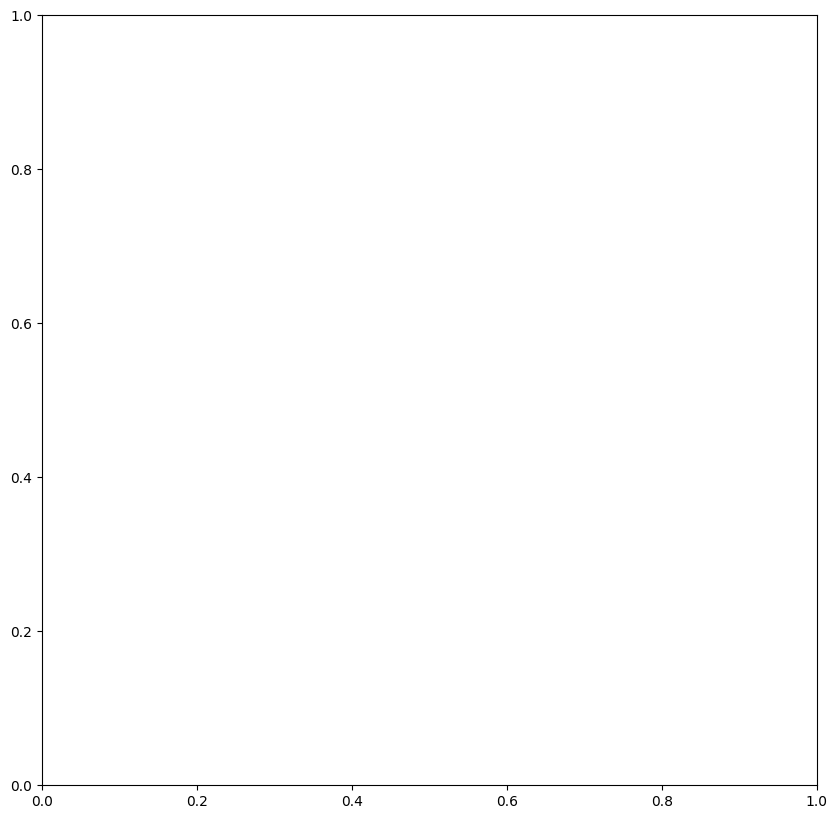

In [30]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import numpy as np


def update(frame, screen, black_hole, rays, ax):
    # Clear the existing plot details
    ax.clear()

    # Update the position and direction of the rays based on gravity
    for ray in rays:
        gravitational_force = black_hole.gravitational_force(ray)
        ray.apply_gravity(gravitational_force)
        ray.move()  # You might need a method to move the ray forward by a step

    # Visualize the scene
    visualize_scene(screen, rays, black_hole, ax)


def visualize_scene(screen, rays, black_hole, ax):
    # Set the limits
    ax.set_xlim(-screen.width, 2 * screen.width)
    ax.set_ylim(-screen.height, 2 * screen.height)
    ax.set_aspect("equal", "box")

    # Draw the Black Hole with a color gradient
    theta = np.linspace(0, 2 * np.pi, 100)
    r = black_hole.radius
    x = r * np.cos(theta) + black_hole.center.x
    y = r * np.sin(theta) + black_hole.center.y
    colors = theta
    ax.scatter(x, y, c=colors, cmap="viridis", s=10)

    # Plot the rays
    for ray in rays:
        end_x = ray.current_position.x
        end_y = ray.current_position.y
        ax.plot([ray.start.x, end_x], [ray.start.y, end_y], color="blue")

    # Render the screen as a collection of points or pixels where rays hit
    # TODO: Assign colors based on ray's end position
    for ray in rays:
        ax.scatter(
            ray.start.x, ray.start.y, color="red"
        )  # This is a placeholder. You might want to map the end position to a color.


# Initialize
screen = Screen(10, 10)
rays = screen.emit_rays(10, 10)
black_hole = BlackHole(Point(5, 5), 2, 1000000)

fig, ax = plt.subplots(figsize=(10, 10))
ani = FuncAnimation(
    fig, update, frames=range(100), fargs=[screen, black_hole, rays, ax], repeat=False
)

plt.show()